In [1]:
import json
import pandas as pd
from pathlib import Path
from pprint import pprint
import datetime
import time
import numpy as np
import matplotlib as plt

import pandas
import researchpy as rp
import seaborn as sns

import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.multicomp

%matplotlib inline

In [2]:
path_results = Path('/media/discoD/models/elmo/ner/results_75_epochs_ibm/')

In [3]:
for folder in path_results.iterdir():
    print(folder)

/media/discoD/models/elmo/ner/results_75_epochs_ibm/harem
/media/discoD/models/elmo/ner/results_75_epochs_ibm/harem-ft


In [4]:
configs = dict()
metrics = dict()
for folder in path_results.iterdir():
    results_model_folder = folder.iterdir()
    for training_folder in results_model_folder:
        #print('Reading files from %s' % training_folder.name)
        has_metrics = False
        for results_file in training_folder.iterdir():
            if results_file.name.endswith('.json'):
                #print('Parsing data from %s' % results_file.name)
                if results_file.name.startswith('config'):
                    configs[training_folder.name] = json.loads(results_file.read_bytes())
                elif results_file.name.startswith('metrics.'):
                    metrics[training_folder.name] = json.loads(results_file.read_bytes())
                    has_metrics = True
        if not has_metrics:
            print('metrics.json not found for %s' % training_folder.name)
            del configs[training_folder.name] 

metrics.json not found for selective_harem_fasttext_64_0_0_1
metrics.json not found for selective_harem_wang2vec_64_0_6_0
metrics.json not found for selective_harem-ft_fasttext_64_0_1_0
metrics.json not found for selective_harem-ft_fasttext_64_0_1_1
metrics.json not found for selective_harem-ft_fasttext_64_0_2_0
metrics.json not found for selective_harem-ft_none_64_0_9_0
metrics.json not found for selective_harem-ft_wang2vec_64_0_2_0
metrics.json not found for selective_harem-ft_word2vec_64_0_2_0
metrics.json not found for selective_harem-ft_glove_64_0_2_0
metrics.json not found for selective_harem-ft_none_64_0_0_0
metrics.json not found for selective_harem-ft_none_64_0_2_0


In [5]:
len(metrics)

92

In [6]:
len(configs)

92

In [7]:
def get_seconds(time_str):
    x = time.strptime(time_str,'%H:%M:%S')
    return datetime.timedelta(hours=x.tm_hour,minutes=x.tm_min,seconds=x.tm_sec).total_seconds()

In [8]:
def get_average_epoch_duration(metrics):
    seconds = get_seconds(metrics['training_duration'])
    training_epochs = metrics['training_epochs'] + 1
    return seconds / training_epochs

In [9]:
TRAINING_ID = 'Training_ID'
SCENARIO = 'Scenario'
MODEL = 'Model'
EMBEDDING = 'Embedding'
BATCH_SIZE = 'Batch_Size'
ELMO_DROPOUT = 'ELMo_Dropout'
TRAINING_NUMBER = 'Training_Number'
EXECUTION_NUMBER = 'Execution_Number'
BEST_EPOCH = 'Best_Epoch'
TRAINING_EPOCHS = 'Training_Epochs'
TRAINING_DURATION = 'Training_Duration'
TOTAL_DURATION = 'Total_Duration(s)'
AVERAGE_EPOCH_DURATION = 'Average_Epoch_Duration(s)'
TRAINING_ACCURACY = 'Training_Accuracy'
TRAINING_ACCURACY_TOP3 = 'Training_Accuracy_Top-3'
TRAINING_PRECISION = 'Training_Precision'
TRAINING_RECALL = 'Training_Recall'
TRAINING_F1_MEASURE = 'Training_F1-Measure'
TRAINING_LOSS = 'Training_Loss'
BEST_VALIDATION_ACCURACY = 'Best_Validation_Accuracy'
BEST_VALIDATION_ACCURACY_TOP3 = 'Best_Validation_Accuracy_Top-3'
BEST_VALIDATION_PRECISION = 'Best_Validation_Precision'
BEST_VALIDATION_RECALL = 'Best_Validation_Recall'
BEST_VALIDATION_F1_MEASURE = 'Best_Validation_F1-Measure'
BEST_VALIDATION_LOSS = 'Best_Validation_Loss'
TEST_ACCURACY = 'Test_Accuracy'
TEST_ACCURACY_TOP3 = 'Test_Accuracy_Top-3'
TEST_PRECISION = 'Test_Precision'
TEST_RECALL = 'Test_Recall'
TEST_F1_MEASURE = 'Test_F1_Measure'
TEST_LOSS = 'Test_Loss'

In [10]:
columns = [TRAINING_ID, SCENARIO, MODEL, EMBEDDING, BATCH_SIZE, ELMO_DROPOUT, TRAINING_NUMBER, EXECUTION_NUMBER, BEST_EPOCH, TRAINING_EPOCHS, TRAINING_DURATION, TOTAL_DURATION, AVERAGE_EPOCH_DURATION, TRAINING_ACCURACY, TRAINING_ACCURACY_TOP3, TRAINING_PRECISION, TRAINING_RECALL, TRAINING_F1_MEASURE, TRAINING_LOSS, BEST_VALIDATION_ACCURACY, BEST_VALIDATION_ACCURACY_TOP3, BEST_VALIDATION_PRECISION, BEST_VALIDATION_RECALL, BEST_VALIDATION_F1_MEASURE, BEST_VALIDATION_LOSS, TEST_ACCURACY, TEST_ACCURACY_TOP3, TEST_PRECISION, TEST_RECALL, TEST_F1_MEASURE, TEST_LOSS]

In [11]:
columns

['Training_ID',
 'Scenario',
 'Model',
 'Embedding',
 'Batch_Size',
 'ELMo_Dropout',
 'Training_Number',
 'Execution_Number',
 'Best_Epoch',
 'Training_Epochs',
 'Training_Duration',
 'Total_Duration(s)',
 'Average_Epoch_Duration(s)',
 'Training_Accuracy',
 'Training_Accuracy_Top-3',
 'Training_Precision',
 'Training_Recall',
 'Training_F1-Measure',
 'Training_Loss',
 'Best_Validation_Accuracy',
 'Best_Validation_Accuracy_Top-3',
 'Best_Validation_Precision',
 'Best_Validation_Recall',
 'Best_Validation_F1-Measure',
 'Best_Validation_Loss',
 'Test_Accuracy',
 'Test_Accuracy_Top-3',
 'Test_Precision',
 'Test_Recall',
 'Test_F1_Measure',
 'Test_Loss']

In [12]:
def get_elmo_dropout(config):
    return config['model']['text_field_embedder']['token_embedders']['elmo']['dropout']

def get_training_data_from_id(training_id, config):
    data = training_id.split('_')
    if len(data) == 6:
        #No ELMo dropout
        return {SCENARIO: data[0], MODEL: data[1], EMBEDDING: data[2], BATCH_SIZE: data[3], ELMO_DROPOUT: get_elmo_dropout(config), TRAINING_NUMBER: data[4]}
    elif len(data) == 7:
        #With ELMo dropout
        return {SCENARIO: data[0], MODEL: data[1], EMBEDDING: data[2], BATCH_SIZE: data[3], ELMO_DROPOUT: data[4], TRAINING_NUMBER: data[5], EXECUTION_NUMBER: data[6]}
    else:
        print('Invalid id: %s' % training_id)

In [13]:
training_data = []
for training_id, config in configs.items():
    training_metrics = metrics[training_id]
    data = get_training_data_from_id(training_id, config)
    data[TRAINING_ID] = training_id
    data[BEST_EPOCH] = training_metrics['best_epoch'] if training_metrics else None
    data[TRAINING_EPOCHS] = training_metrics['training_epochs'] + 1 if training_metrics else None
    data[TRAINING_DURATION] = training_metrics['training_duration'] if training_metrics else None
    data[TOTAL_DURATION] = get_seconds(training_metrics['training_duration']) if training_metrics else None
    data[AVERAGE_EPOCH_DURATION] = get_average_epoch_duration(training_metrics) if training_metrics else None
    data[TRAINING_ACCURACY] = training_metrics['training_accuracy'] if training_metrics else None
    data[TRAINING_ACCURACY_TOP3] = training_metrics['training_accuracy3'] if training_metrics else None
    data[TRAINING_PRECISION] = training_metrics['training_precision-overall'] if training_metrics else None
    data[TRAINING_RECALL] = training_metrics['training_recall-overall'] if training_metrics else None
    data[TRAINING_F1_MEASURE] = training_metrics['training_f1-measure-overall'] if training_metrics else None
    data[TRAINING_LOSS] = training_metrics['training_loss'] if training_metrics else None
    data[BEST_VALIDATION_ACCURACY] = training_metrics['best_validation_accuracy'] if training_metrics else None
    data[BEST_VALIDATION_ACCURACY_TOP3] = training_metrics['best_validation_accuracy3'] if training_metrics else None
    data[BEST_VALIDATION_PRECISION] = training_metrics['best_validation_precision-overall'] if training_metrics else None
    data[BEST_VALIDATION_RECALL] = training_metrics['best_validation_recall-overall'] if training_metrics else None
    data[BEST_VALIDATION_F1_MEASURE] = training_metrics['best_validation_f1-measure-overall'] if training_metrics else None
    data[BEST_VALIDATION_LOSS] = training_metrics['best_validation_loss'] if training_metrics else None
    data[TEST_ACCURACY] = training_metrics['test_accuracy'] if training_metrics else None
    data[TEST_ACCURACY_TOP3] = training_metrics['test_accuracy3'] if training_metrics else None
    data[TEST_PRECISION] = training_metrics['test_precision-overall'] if training_metrics else None
    data[TEST_RECALL] = training_metrics['test_recall-overall'] if training_metrics else None
    data[TEST_F1_MEASURE] = training_metrics['test_f1-measure-overall'] if training_metrics else None
    data[TEST_LOSS] = training_metrics['test_loss'] if training_metrics else None
    training_data.append(data)

In [14]:
pd.set_option('display.max_columns', 1000)
training_data_df = pd.DataFrame(training_data, columns=columns)
training_data_df

,Training_ID,Scenario,Model,Embedding,Batch_Size,ELMo_Dropout,Training_Number,Execution_Number,Best_Epoch,Training_Epochs,Training_Duration,Total_Duration(s),Average_Epoch_Duration(s),Training_Accuracy,Training_Accuracy_Top-3,Training_Precision,Training_Recall,Training_F1-Measure,Training_Loss,Best_Validation_Accuracy,Best_Validation_Accuracy_Top-3,Best_Validation_Precision,Best_Validation_Recall,Best_Validation_F1-Measure,Best_Validation_Loss,Test_Accuracy,Test_Accuracy_Top-3,Test_Precision,Test_Recall,Test_F1_Measure,Test_Loss
0,selective_harem_glove_64_0_4_0,selective,harem,glove,64,0,4,0,30,55,00:59:58,3598.0,65.418182,0.999785,0.999785,0.997017,0.998099,0.997558,1.036890,0.986924,0.988212,0.905707,0.875300,0.890244,114.903158,0.978702,0.980548,0.831209,0.805676,0.818243,234.850057
1,selective_harem_wang2vec_64_0_1_0,selective,harem,wang2vec,64,0,1,0,55,75,01:22:09,4929.0,65.720000,0.999763,0.999785,0.996504,0.997041,0.996772,1.212928,0.988847,0.990042,0.894330,0.906005,0.900130,138.697021,0.978266,0.979962,0.822094,0.810017,0.816011,299.015625
2,selective_harem_fasttext_64_0_0_0,selective,harem,fasttext,64,0,0,0,11,36,00:39:08,2348.0,65.222222,0.999451,0.999507,0.994064,0.993528,0.993796,2.270200,0.980221,0.982843,0.832905,0.826531,0.829706,121.311896,0.976946,0.979047,0.845216,0.763940,0.802525,173.167292
3,selective_harem_fasttext_64_0_1_0,selective,harem,fasttext,64,0,1,0,46,71,01:16:50,4610.0,64.929577,0.999740,0.999751,0.996774,0.997579,0.997176,0.909094,0.988050,0.989345,0.893782,0.900783,0.897269,136.212775,0.976570,0.978477,0.797987,0.793990,0.795983,297.775065
4,selective_harem_fasttext_64_0_2_0,selective,harem,fasttext,64,0,2,0,19,44,00:46:55,2815.0,63.977273,0.999625,0.999659,0.995316,0.995316,0.995316,1.457602,0.987156,0.988210,0.866255,0.893843,0.879833,88.992603,0.978356,0.980143,0.830084,0.795993,0.812681,188.515346
5,selective_harem_fasttext_64_0_3_0,selective,harem,fasttext,64,0,3,0,63,75,01:20:04,4804.0,64.053333,0.999775,0.999786,0.996752,0.997292,0.997022,0.901221,0.985300,0.986232,0.851415,0.886978,0.868833,189.703421,0.978386,0.980218,0.839267,0.794992,0.816529,325.781593
6,selective_harem_fasttext_64_0_4_0,selective,harem,fasttext,64,0,4,0,40,65,01:09:53,4193.0,64.507692,0.999898,0.999909,0.998913,0.997828,0.998370,0.648463,0.988212,0.989203,0.897810,0.884892,0.891304,119.601767,0.978432,0.980233,0.826057,0.808681,0.817277,263.840038
7,selective_harem_fasttext_64_0_5_0,selective,harem,fasttext,64,0,5,0,16,41,00:43:56,2636.0,64.292683,0.999492,0.999549,0.993491,0.994030,0.993760,2.087307,0.986908,0.987821,0.872038,0.886747,0.879331,100.888163,0.977726,0.979587,0.828023,0.807012,0.817382,178.163484
8,selective_harem_fasttext_64_0_6_0,selective,harem,fasttext,64,0,6,0,49,74,01:18:33,4713.0,63.689189,0.999740,0.999751,0.997291,0.997291,0.997291,1.186898,0.989521,0.990519,0.885922,0.894608,0.890244,130.281740,0.977696,0.979617,0.820845,0.804674,0.812679,305.549114
9,selective_harem_fasttext_64_0_7_0,selective,harem,fasttext,64,0,7,0,25,50,00:54:03,3243.0,64.860000,0.999561,0.999595,0.994065,0.995408,0.994736,1.790046,0.987957,0.989410,0.902256,0.904523,0.903388,102.777653,0.977621,0.979677,0.826741,0.788648,0.807245,225.161508


In [15]:
training_data_df = training_data_df[training_data_df.Scenario == 'selective']
len(training_data_df)

92

In [16]:
training_data_df.to_csv('training_data_75_epochs.csv')

In [17]:
training_data_df.groupby([MODEL]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
Model,,,,,,,,
harem-ft,43.0,0.817089,0.005456,0.801582,0.813599,0.817587,0.820646,0.828528
harem,49.0,0.813167,0.005364,0.795983,0.810802,0.814024,0.816627,0.826072


In [18]:
training_data_df.groupby([EMBEDDING]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
Embedding,,,,,,,,
wang2vec,18.0,0.816548,0.004773,0.809356,0.812598,0.816267,0.818462,0.828528
glove,19.0,0.816042,0.005475,0.802897,0.813271,0.817805,0.818995,0.825311
none,17.0,0.815958,0.006631,0.800870,0.812936,0.816381,0.819806,0.826072
fasttext,19.0,0.813318,0.006808,0.795983,0.809899,0.815719,0.817330,0.821538
word2vec,19.0,0.813317,0.004296,0.801582,0.811334,0.814213,0.815937,0.819482


In [19]:
training_data_df.groupby([EMBEDDING, MODEL]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

,,count,mean,std,min,25%,50%,75%,max
Embedding,Model,,,,,,,,
glove,harem-ft,9.0,0.819504,0.003105,0.814652,0.817805,0.819248,0.821570,0.825311
none,harem-ft,7.0,0.819381,0.004801,0.812936,0.816298,0.817587,0.823237,0.826072
wang2vec,harem-ft,9.0,0.818006,0.006165,0.809356,0.812543,0.818473,0.822366,0.828528
fasttext,harem-ft,9.0,0.816133,0.005349,0.805678,0.812814,0.817052,0.820069,0.821538
wang2vec,harem,9.0,0.815090,0.002370,0.811717,0.812765,0.816008,0.816523,0.818431
word2vec,harem,10.0,0.813665,0.003134,0.808106,0.811988,0.814119,0.815323,0.819482
none,harem,10.0,0.813562,0.006878,0.800870,0.809536,0.813663,0.816566,0.826072
word2vec,harem-ft,9.0,0.812930,0.005490,0.801582,0.809360,0.814220,0.816858,0.818890
glove,harem,10.0,0.812926,0.005348,0.802897,0.809424,0.813616,0.817801,0.818243


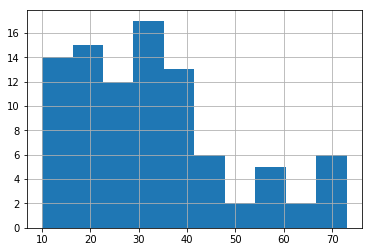

In [20]:
training_data_df[BEST_EPOCH].hist()

In [21]:
training_data_df[TOTAL_DURATION].describe()

count      92.000000
mean     3665.597826
std       817.440162
min      2260.000000
25%      2913.250000
50%      3621.500000
75%      4213.750000
max      5346.000000
Name: Total_Duration(s), dtype: float64

In [22]:
training_data_df.groupby([TRAINING_NUMBER]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
Training_Number,,,,,,,,
5,10.0,0.819258,0.005060,0.812765,0.816097,0.818458,0.821195,0.828528
4,10.0,0.818423,0.003470,0.814213,0.816443,0.817186,0.819415,0.825311
3,10.0,0.816713,0.004963,0.809356,0.813613,0.816653,0.817057,0.826072
6,9.0,0.815625,0.004353,0.809114,0.812679,0.815719,0.818473,0.823125
8,10.0,0.815546,0.003409,0.808935,0.814319,0.816161,0.817450,0.819806
7,10.0,0.814579,0.005815,0.807245,0.809996,0.812495,0.820688,0.822366
0,10.0,0.813621,0.006248,0.802525,0.812836,0.815404,0.817493,0.821223
2,5.0,0.813498,0.004031,0.808106,0.811891,0.812681,0.816383,0.818431
1,9.0,0.810843,0.008036,0.795983,0.807339,0.812978,0.816214,0.818741


In [23]:
rp.summary_cont(training_data_df[TEST_F1_MEASURE])

,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,Test_F1_Measure,92.0,0.815,0.005726,0.000597,0.813814,0.816186


In [24]:
rp.summary_cont(training_data_df.groupby(MODEL))[TEST_F1_MEASURE]

,N,Mean,SD,SE,95% Conf.,Interval
Model,,,,,,
harem,49,0.813167,0.005364,0.000766,0.811665,0.814669
harem-ft,43,0.817089,0.005456,0.000832,0.815458,0.818720


In [25]:
rp.summary_cont(training_data_df.groupby(EMBEDDING))[TEST_F1_MEASURE]

,N,Mean,SD,SE,95% Conf.,Interval
Embedding,,,,,,
fasttext,19,0.813318,0.006808,0.001562,0.810257,0.816379
glove,19,0.816042,0.005475,0.001256,0.813580,0.818503
none,17,0.815958,0.006631,0.001608,0.812806,0.819110
wang2vec,18,0.816548,0.004773,0.001125,0.814343,0.818753
word2vec,19,0.813317,0.004296,0.000985,0.811386,0.815249


In [26]:
rp.summary_cont(training_data_df.groupby([MODEL,EMBEDDING]))[TEST_F1_MEASURE]

N      Mean        SD        SE  95% Conf.  Interval
Model    Embedding                                                       
harem    fasttext   10  0.810785  0.007227  0.002285   0.806306  0.815264
         glove      10  0.812926  0.005348  0.001691   0.809611  0.816240
         none       10  0.813562  0.006878  0.002175   0.809299  0.817825
         wang2vec    9  0.815090  0.002370  0.000790   0.813541  0.816638
         word2vec   10  0.813665  0.003134  0.000991   0.811723  0.815608
harem-ft fasttext    9  0.816133  0.005349  0.001783   0.812638  0.819627
         glove       9  0.819504  0.003105  0.001035   0.817475  0.821532
         none        7  0.819381  0.004801  0.001815   0.815824  0.822937
         wang2vec    9  0.818006  0.006165  0.002055   0.813978  0.822034
         word2vec    9  0.812930  0.005490  0.001830   0.809343  0.816517

In [27]:
print(TEST_F1_MEASURE, MODEL, EMBEDDING, BATCH_SIZE, ELMO_DROPOUT)

Test_F1_Measure Model Embedding Batch_Size ELMo_Dropout


In [28]:
# Calculating effect size
def anova_table(aov):
    aov['mean_sq'] = aov[:]['sum_sq']/aov[:]['df']
    
    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])
    
    aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*aov['mean_sq'][-1]))/(sum(aov['sum_sq'])+aov['mean_sq'][-1])
    
    cols = ['sum_sq', 'mean_sq', 'df', 'F', 'PR(>F)', 'eta_sq', 'omega_sq']
    aov = aov[cols]
    return aov

def print_anova(parameter):
    # Fits the model with the interaction term
    # This will also automatically include the main effects for each factor
    model = ols('Test_F1_Measure ~ C({0})'.format(parameter), training_data_df).fit()
    # Seeing if the overall model is significant
    print(f"Overall model F({model.df_model: .0f},{model.df_resid: .0f}) = {model.fvalue: .3f}, p = {model.f_pvalue: .20f}")
    print(model.summary())
    res = sm.stats.anova_lm(model, typ= 2)
    print(res)
    print(anova_table(res))
    mc = statsmodels.stats.multicomp.MultiComparison(training_data_df[TEST_F1_MEASURE], training_data_df[parameter])
    mc_results = mc.tukeyhsd()
    print(mc_results)

In [29]:
print_anova(MODEL)

Overall model F( 1, 90) =  12.048, p =  0.00079849460733752149
                            OLS Regression Results                            
Dep. Variable:        Test_F1_Measure   R-squared:                       0.118
Model:                            OLS   Adj. R-squared:                  0.108
Method:                 Least Squares   F-statistic:                     12.05
Date:                Thu, 18 Apr 2019   Prob (F-statistic):           0.000798
Time:                        12:00:45   Log-Likelihood:                 350.71
No. Observations:                  92   AIC:                            -697.4
Df Residuals:                      90   BIC:                            -692.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------

In [30]:
print_anova(EMBEDDING)

Overall model F( 4, 87) =  1.454, p =  0.22333818421176165891
                            OLS Regression Results                            
Dep. Variable:        Test_F1_Measure   R-squared:                       0.063
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     1.454
Date:                Thu, 18 Apr 2019   Prob (F-statistic):              0.223
Time:                        12:00:45   Log-Likelihood:                 347.91
No. Observations:                  92   AIC:                            -685.8
Df Residuals:                      87   BIC:                            -673.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------